## Week - 06 Bidirectional LSTM | SoC 2025 - AnimAI Project 

For this week work, it'll be better if you have GPU facility, if you dont have an inbuilt GPU in your laptop, it is reccomended that you use Google Colab or Kaggle for this notebook, ensure that you select `T4 GPU` in `Runtime` options if you are on Google Colab.

In [1]:
""" 
# Uncomment the following lines to check if TensorFlow can access the GPU.
# Make sure you have TensorFlow installed in your environment.
import tensorflow as tf
print("GPU available:", tf.test.is_gpu_available())
"""

' \n# Uncomment the following lines to check if TensorFlow can access the GPU.\n# Make sure you have TensorFlow installed in your environment.\nimport tensorflow as tf\nprint("GPU available:", tf.test.is_gpu_available())\n'

In this final week, we aim to train a convolutional neural network (CNN) on our dataset. But before jumping into the model, we must take a small but important detour into a few core ideas from Linear Algebra and a little probability. These concepts will clarify why we often need to shift and scale data before training neural networks, why Batch Normalization is used, and why we must reverse certain operations after prediction.

Let us begin with a fundamental question that will guide our intuition:

### Can a Linear Transformation Shift the Origin?

Suppose we have a point $P(x_1, y_1)$, and we want to shift the origin of our coordinate system to this new point. Can we achieve this using a **linear transformation**?

Recall the definition of a linear transformation:

A function  
$$
T: \mathbb{R}^n \rightarrow \mathbb{R}^m
$$  
is **linear** if it satisfies the following two properties for all vectors $\vec{u}, \vec{v}$ and scalar $c$:

1. **Additivity**:  
   $$
   T(\vec{u} + \vec{v}) = T(\vec{u}) + T(\vec{v})
   $$

2. **Homogeneity**:  
   $$
   T(c \cdot \vec{v}) = c \cdot T(\vec{v})
   $$

Let’s test what this implies about the origin. Consider the zero vector $\vec{0}$. Using the homogeneity property:

$$
T(0 \cdot \vec{v}) = 0 \cdot T(\vec{v}) = \vec{0}
$$

This tells us that any linear transformation **must** map the origin to the origin. Therefore, we cannot use a linear transformation to shift the origin to some new point $P(x_1, y_1)$. In other words, **linear transformations can stretch, rotate, reflect, or project the space, but they cannot move the origin**.

To move the origin, we need something more general than a linear transformation.

Let’s define the following transformation:  
$$
T(\vec{x}) = \vec{x} + \begin{bmatrix} 1 \\ 2 \end{bmatrix}
$$

Now apply it to the origin:  
$$
T(\vec{0}) = \vec{0} + \begin{bmatrix} 1 \\ 2 \end{bmatrix} = \begin{bmatrix} 1 \\ 2 \end{bmatrix}
$$

This transformation **moves** the origin to a new point. But since it does not preserve the condition $T(\vec{0}) = \vec{0}$, it is **not linear**. Instead, it is known as an **affine transformation** if you remember.

An affine transformation is of the form:  
$$
T(\vec{x}) = A\vec{x} + \vec{b}
$$  
where $A$ is a matrix (like in linear transformations) and $\vec{b}$ is a constant vector that shifts the output. This $\vec{b}$ term is exactly what allows us to shift the origin.

However, if you want to shift the origin using a linear transformation, there is a clever workaround: **homogeneous coordinates**. By adding an extra coordinate to each point, for example representing $P(x_1, y_1)$ as $P(x_1, y_1, 1)$, we can use a $3 \times 3$ matrix to perform both linear and translation (shift) operations.

For instance, to shift the origin by $(4, 2)$, we use the following transformation matrix:
$$
\begin{bmatrix}
1 & 0 & 4 \\
0 & 1 & 2 \\
0 & 0 & 1 \\
\end{bmatrix}
$$

Applying this matrix to a point in homogeneous coordinates:
$$
\begin{bmatrix}
1 & 0 & 4 \\
0 & 1 & 2 \\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\
y_1 \\
1 \\
\end{bmatrix}
=
\begin{bmatrix}
x_1 + 4 \\
y_1 + 2 \\
1 \\
\end{bmatrix}
$$

This approach allows us to represent translations as matrix multiplications, effectively enabling origin shifts within the framework of linear algebra by working in a higher-dimensional space, we can omit that 3rd dimension we introduced

---

### Why Do We Shift the Origin Before Training?

Now let’s turn back to neural networks. When building a model, one of the standard practices is to **center the input data** by subtracting its mean. But why exactly do we do that?

To understand this, consider a neural network layer with the following operation:  
$$
z = \mathbf{w}^T \mathbf{x} + b
$$

Suppose we are using a ReLU activation:  
$$
\text{ReLU}(z) = \max(0, z)
$$

Assume our input vector $\mathbf{x}$ has two features:  
$$
\mathbf{x} = \begin{bmatrix} 400 \\ -600 \end{bmatrix}
$$

and our weight vector is:  
$$
\mathbf{w} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}
$$

Then the output becomes:  
$$
z = 400 + (-600) + b = -200 + b
$$

If $b = 0$, then  
$$
\text{ReLU}(z) = \max(0, -200) = 0
$$

Now we have a problem. This neuron **completely shuts off** and does not contribute to the next layer. This is called a **dead ReLU**. Even if we change weights slightly, if the inputs are large and offset far from zero, it's easy for the affine sum $z$ to stay in the negative region.

On the other hand, if the inputs are always large and positive, then ReLU just becomes an identity function. That also defeats its purpose of introducing non-linearity.

The real issue here is that our data is **centered far from the origin**, which causes the ReLU to behave in unintended ways. To fix this, we subtract the mean from each input dimension and make the average input close to zero.

Once we center the data to:  
$$
\mathbf{x}_{\text{new}} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}
$$  
we get:  
$$
z = \mathbf{w}^T \mathbf{x}_{\text{new}} + b = 0 + b
$$

Now the bias $b$ plays a meaningful role, and the neuron can output positive or negative values depending on learned parameters. Shifting the origin makes the network more sensitive to variations in input rather than being overwhelmed by large constants.

---

### Why Scaling the Data is Equally Important

Shifting alone is not enough. Suppose you have two input features: one ranges from 390 to 410, and the other ranges from -2000 to -100. Even if both are centered around zero, their **variances are vastly different**.

This discrepancy creates a problem during training. The larger variance feature contributes more to the dot product $\mathbf{w}^T \mathbf{x}$, simply due to its magnitude. As a result, the model may ignore the smaller-variance features unless you carefully adjust the weights.

More importantly, this imbalance affects gradient-based optimizers like SGD or Adam. Since gradients are proportional to input values, high-variance features will generate **larger gradients**, causing their weights to update quickly. Meanwhile, low-variance features generate smaller gradients, and their learning becomes sluggish.

To solve this, we scale each input feature to have **unit variance** (or close to it). This is usually done as:  
$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$  
where $\mu$ is the mean and $\sigma$ is the standard deviation of the feature.

Once the input features are scaled uniformly, the optimizer treats them fairly, and the learning rate becomes effective across all weights.

---

### The Role of Batch Normalization

We will make this shifting and normalisation to the input data, that is fine, But even with careful input normalization, the values inside a neural network can drift during training, Why? because the perceptrons (neurons) do **Affine Transformation** too. To address this, we use **Batch Normalization**, which standardizes the inputs to each layer across the mini-batch.

The formula is:  
$$
\text{BN}(x) = \gamma \cdot \frac{x - \mu_{\text{batch}}}{\sqrt{\sigma_{\text{batch}}^2 + \epsilon}} + \beta
$$

Here, $\mu_{\text{batch}}, \sigma_{\text{batch}} \text{ are computed over the current mini-batch}$ and $\gamma, \beta \text{ are learnable parameters that let the model re-scale and shift the normalized outputs}$

BatchNorm helps keep the internal representations well-behaved:
- It keeps inputs to activation functions like ReLU centered and scaled
- It prevents vanishing and exploding gradients
- It allows for larger learning rates
- It acts as a form of regularization

However, Batch Normalization **does not replace** input normalization.

The first layer in a neural network receives raw input. If that input is not centered and scaled, then all the issues we discussed earlier large dot products, ineffective biases, dead activations still happen **before** BatchNorm ever gets applied. That's why it's critical to normalize the inputs **before** training begins, in addition to using BatchNorm inside the model.

### Why Not Use Batch Normalization at the Input Instead of Manual Normalization?

If we can use Batch Normalization in between hidden layers, why don’t we use the same at the input layer also instead of manually doing it?

It sounds reasonable right?, but manual input normalization is still necessary and preferred:

1. **BatchNorm is meant to normalize the output of an affine transformation**, i.e., $z = \mathbf{w}^T \mathbf{x} + b$. But raw input data hasn't gone through any such transformation yet, applying BatchNorm directly on it can be unstable, especially if the input is sparse, skewed, or noisy.

2. **BatchNorm uses batch statistics during training and running averages during inference**. This discrepancy is fine for internal layers, because the network can learn to compensate. But at the input layer, there's no previous layer to absorb the inconsistency, leading to unreliable performance at test time.

3. **Manual normalization (something like subtracting dataset mean and dividing by std)** is stable and consistent. It uses fixed statistics computed over the entire dataset, applies equally during training and inference, and can be easily inverted during post-processing.

4. **BatchNorm is a learnable layer**, meaning it adapts over time. But input normalization is not something we want to "learn", we want it to be a clean, fixed transformation, not dependent on training batches. For example, if your input feature has a wide range and your batch size is small (say 4), BatchNorm might estimate wildly inaccurate means and variances, causing erratic behavior in the first layer. This instability isn't a concern for hidden layers where the model can adapt, but it is critical for the input.


So while technically possible to place a `BatchNormalization` layer after the input, it’s not a reliable replacement for manual normalization. Best practice is to:
- Manually normalize input data before training,
- Then use BatchNorm in the hidden layers to stabilize internal activations.

This combination ensures both input consistency and robust learning dynamics, Note that there are other ways to do this pre-processing, one of the famous ways is used in this notebook involving `sklearn`, try to understand how it works, that function is named : `normalize_keypoints_center_scale`.


### Inverting the Normalization After Prediction

Suppose we have trained our network on input data that was centered and scaled. What does this mean for the output?

The network has now learned to make predictions in the **transformed (normalized) space**. If this were a classification task, we wouldn't worry much. But in a regression task, like predicting prices, temperatures, or pixel intensities (our case) the outputs must make sense in **real-world units**.

This means we must **undo** the normalization after prediction. If our pre-processing was:  
$$
x_{\text{norm}} = \frac{x - \mu}{\sigma}
$$  
then the inverse transformation is:  
$$
x_{\text{original}} = x_{\text{norm}} \cdot \sigma + \mu
$$

This step is called **denormalization** or **post-processing**, and it is essential to interpret the predictions correctly.

Now let's load our dataset and retrieve the subject 'S7' 'Walking' just as we did in `week-04`

In [2]:
import os
import urllib.request
import subprocess

import warnings
warnings.filterwarnings("ignore")
# This script checks if the VideoPose3D repository exists locally on your PC, clones it if not,
# it downloads our dataset called Human3.6M if it is not already present.

if not os.path.exists("VideoPose3D"):
    subprocess.run(["git", "clone", "https://github.com/facebookresearch/VideoPose3D.git"])

# Download dataset if not exists
data_path = "VideoPose3D/data/data_2d_h36m_cpn_ft_h36m_dbb.npz"
os.makedirs(os.path.dirname(data_path), exist_ok=True)

if not os.path.exists(data_path):
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/video-pose-3d/data_2d_h36m_cpn_ft_h36m_dbb.npz",
        data_path
    )
    print("Dataset downloaded.")
else:
    print("Dataset already exists. You can start using it directly.")


Dataset already exists. You can start using it directly.


In [3]:
import numpy as np
# Load dataset
data = np.load(data_path, allow_pickle=True) # allow_pickle=True allows loading of objects stored in the file, such as dictionaries or lists.
print(data.files)  # List all available files in the dataset

metadata = data['metadata'].item()
print(type(metadata))
print(metadata.keys())

positions = data['positions_2d'].item()

print(type(positions))  # type of positions is a dictionary
print(len(positions))   # number of subjects in the dataset
print("Subjects:", list(positions.keys()))             # number of people's motion in the dataset
print("Actions for S7:", list(positions['S7'].keys())) # Inspect actions for subject S2(one person)
print("Shape of S7 - Walking 1 - Cam 0:", positions['S7']['Walking 1'][0].shape) # Inspect shape of keypoints for a specific action and camera

['positions_2d', 'metadata']
<class 'dict'>
dict_keys(['layout_name', 'num_joints', 'keypoints_symmetry'])
<class 'dict'>
10
Subjects: ['S6', 'S7', 'S5', 'S11', 'S1', 'S9', 'S8', 'S2', 'S3', 'S4']
Actions for S7: ['Directions 1', 'Discussion 1', 'Eating 1', 'Greeting 1', 'Phoning 2', 'Posing 1', 'Purchases 1', 'Sitting 1', 'SittingDown', 'Smoking 1', 'Photo', 'Waiting 1', 'Walking 1', 'WalkDog 1', 'WalkTogether 1', 'Directions', 'Discussion', 'Eating', 'Greeting', 'Phoning', 'Posing', 'Purchases', 'Sitting', 'SittingDown 1', 'Smoking', 'Photo 1', 'Waiting 2', 'Walking 2', 'WalkDog', 'WalkTogether']
Shape of S7 - Walking 1 - Cam 0: (3637, 17, 2)


In [4]:
## defining subject and action

subject = 'S7' # Subject S7 is one of the subjects in the dataset, can change to any other subject like S1, S2, etc.
action = 'Walking 1' # Action 'Walking 1' is one of the actions performed by the subject, can change to any other action like 'Eating', 'Smoking', etc.

keypoints_all = positions[subject][action][0]  # Camera view 0 (4 cameras available: 0,1,2,3)
# keypoints_all is a numpy array of shape (n_frames, 17, 2) where n_frames is the number of frames in the video, 17 is the number of joints, and 2 represents x and y coordinates of each joint.

keypoints_old = positions[subject][action][0]

## data is copied in two variables to use

print(keypoints_all.shape)

keypoints_reshaped = keypoints_all.reshape(-1, 34)
print(keypoints_reshaped.shape)

(3637, 17, 2)
(3637, 34)


## Dataset Preprocessing - Normalisation and Origin Shift for the Data Points

In [5]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

def normalize_keypoints_center_scale(keypoints_all):
    num_frames, num_joints, _ = keypoints_all.shape

    # Computing mean per frame (shape: num_frames x 1 x 2)
    means = keypoints_all.mean(axis=1, keepdims=True)

    # Centering data by subtracting mean (shift origin to mean joint position)
    centered = keypoints_all - means  # shape (num_frames, 17, 2)

    # Flattening for scaling
    flat_centered = centered.reshape(-1, 2)

    # Fitting scalers on centered data
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    x_scaled = scaler_x.fit_transform(flat_centered[:, 0].reshape(-1, 1)).flatten()
    y_scaled = scaler_y.fit_transform(flat_centered[:, 1].reshape(-1, 1)).flatten()

    scaled_flat = np.stack([x_scaled, y_scaled], axis=1)
    keypoints_normalized = scaled_flat.reshape(num_frames, num_joints, 2)

    return keypoints_normalized, means, scaler_x, scaler_y

# Applying normalization
keypoints_normalized, means, scaler_x, scaler_y = normalize_keypoints_center_scale(keypoints_all)


Missing frame Generation

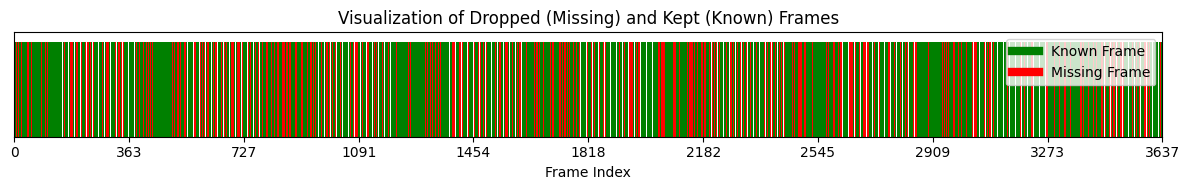

100%|██████████| 61/61 [00:03<00:00, 16.77it/s]


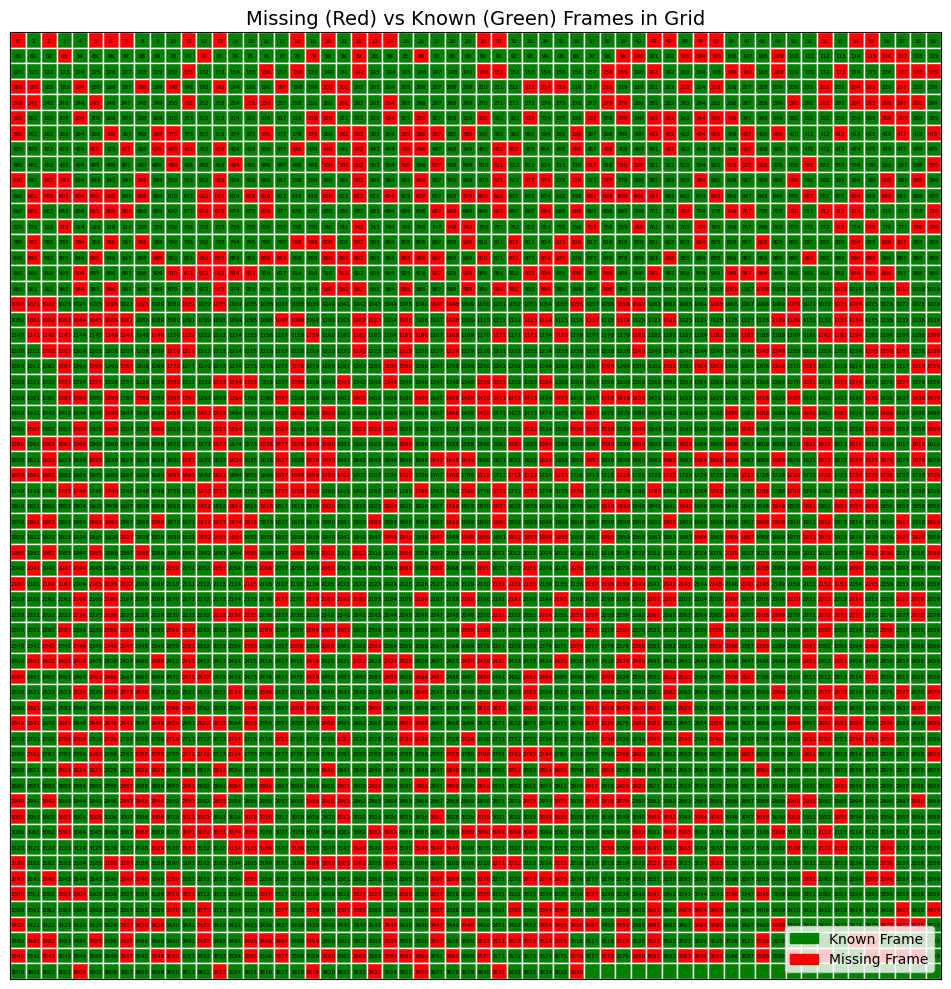

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as mpatches

segment_len = 3637  # Total frames in our data
rng = np.random.default_rng(42)
mask = rng.choice([1, 0], size=segment_len, p=[0.7, 0.3])  # 70% known, 30% missing

# --- Bar plot of known/missing frames ---
fig, ax = plt.subplots(figsize=(12, 2))
for i in range(segment_len):
    color = 'green' if mask[i] == 1 else 'red'
    ax.bar(i, 1, color=color, edgecolor='none', width=0.9, align='center')

ax.set_xlim(0, segment_len)
ax.set_ylim(0, 1.1)
ax.set_xticks(np.linspace(0, segment_len, 11).astype(int))
ax.set_yticks([])
ax.set_xlabel('Frame Index')
ax.set_title('Visualization of Dropped (Missing) and Kept (Known) Frames')

legend_elements = [
    plt.Line2D([0], [0], color='green', lw=6, label='Known Frame'),
    plt.Line2D([0], [0], color='red', lw=6, label='Missing Frame')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

# --- Grid plot ---
# Choose grid size close to sqrt(segment_len)
import math
rows = 61
cols = 60
assert rows * cols >= segment_len, "Grid size must cover all frames"

if rows * cols > segment_len:
    pad_len = rows * cols - segment_len
    mask_padded = np.concatenate([mask, np.ones(pad_len, dtype=int)])  # padding with known frames for visualization
else:
    mask_padded = mask

mask_grid = mask_padded.reshape((rows, cols))

fig, ax = plt.subplots(figsize=(40, 10))
cmap = {0: 'red', 1: 'green'}

for r in tqdm(range(rows)): # we only plotted the first 200 frames during week-04, now we plot all frames, the representation is kind of messy, try to plot it in a better way
    for c in range(cols):
        color = cmap[mask_grid[r, c]]
        rect = plt.Rectangle((c, rows - 1 - r), 1, 1, facecolor=color, edgecolor='white')
        ax.add_patch(rect)
        frame_idx = r * cols + c
        if frame_idx < segment_len:
            ax.text(c + 0.5, rows - 1 - r + 0.5, str(frame_idx),
                    color='black', ha='center', va='center', fontsize=4)

ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Missing (Red) vs Known (Green) Frames in Grid", fontsize=14)

green_patch = mpatches.Patch(color='green', label='Known Frame')
red_patch = mpatches.Patch(color='red', label='Missing Frame')
ax.legend(handles=[green_patch, red_patch], loc='lower right')

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


Batch Generation for Input to Model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Add, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

# Parameters
window_size = 1  # Change if you want a different window size, but keep it consistent with the training data
num_joints = 17
coord_dim = 2
input_dim = num_joints * coord_dim # 34
hidden_dim = 256
batch_size = 32
epochs = 100 # Try to implement early stopping

# The below class is sourced from the VideoPose3D repository, it is a helper class to generate batches of data for training.
class MocapDataGenerator3D(Sequence):
    def __init__(self, keypoints, mask, window_size, batch_size=32):
        self.keypoints = keypoints
        self.mask = mask
        self.window_size = window_size
        self.batch_size = batch_size

        half_w = window_size // 2
        self.indices = [
            i for i in range(half_w, len(keypoints) - half_w)
            if mask[i] == 1
        ]

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []
        half_w = self.window_size // 2
        for center in batch_indices:
            start = center - half_w
            end = center + half_w + 1
            window = self.keypoints[start:end]
            X.append(window.reshape(self.window_size, -1))
            y.append(self.keypoints[center].reshape(-1))
        return np.array(X), np.array(y)

train_gen = MocapDataGenerator3D(keypoints_normalized, mask, window_size=window_size, batch_size=batch_size)


### Building the Model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_model(window_size, input_dim, hidden_dim):
    inputs = Input(shape=(window_size, input_dim))

    x = Bidirectional(LSTM(hidden_dim, return_sequences=True))(inputs) # BiLSTM
    x = Bidirectional(LSTM(hidden_dim))(x)


    x = Dense(hidden_dim * 2, activation='relu')(x)
    x = Dense(hidden_dim, activation='relu')(x)

    # Observe here that we are not using Dropout layers, this is because our dataset is very small and very specific,
    # so we are allowing the model to learn all the features without dropping any.
    # If we later want to train on entire Videopose3D dataset, we can add Dropout layers to prevent overfitting.
    # x = Dropout(0.5)(x)  # Uncomment if you want to add dropout
    outputs = Dense(input_dim, activation='linear')(x)

    return Model(inputs, outputs)


model = build_lstm_model(window_size, input_dim, hidden_dim)
model.compile(optimizer=Adam(1e-3), loss='mse')
model.summary()
model.fit(train_gen, epochs=epochs, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 34)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           595968    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 34)                8738  

In [9]:
def inverse_transform_reconstructed(pred_norm, means, scaler_x, scaler_y, frame_idx): 
    # Step 1: Inverting scale (normalized [0,1] -> centered coordinates)
    x_norm = pred_norm[:, 0].reshape(-1, 1)
    y_norm = pred_norm[:, 1].reshape(-1, 1)

    x_centered = scaler_x.inverse_transform(x_norm).flatten()
    y_centered = scaler_y.inverse_transform(y_norm).flatten()

    pred_centered = np.stack([x_centered, y_centered], axis=1)

    # Step 2: Adding back the mean (centered -> original coordinates)
    pred_original = pred_centered + means[frame_idx].reshape(1, 2)

    return pred_original

In [10]:
keypoints_reconstructed = keypoints_all.copy()  # Starting with original data

for i in tqdm(range(window_size // 2, len(mask) - window_size // 2)):
    if mask[i] == 0:  # missing frame
        # Taking the center frame only (model was trained with window_size=1)
        window = keypoints_reconstructed[i]  # shape: (17, 2)

        # Normalizing the frame (same as training)
        window_centered = window - window.mean(axis=0, keepdims=True)
        x_scaled = scaler_x.transform(window_centered[:, 0].reshape(-1, 1)).flatten()
        y_scaled = scaler_y.transform(window_centered[:, 1].reshape(-1, 1)).flatten()

        # Stacking and reshaping to match model input shape
        window_flat = np.stack([x_scaled, y_scaled], axis=1).reshape(1, 1, -1)  # (1, 1, 34)

        # Predicting
        pred_norm = model.predict(window_flat, verbose=0)[0].reshape(num_joints, coord_dim)

        # Inverse transform
        pred_original = inverse_transform_reconstructed(pred_norm, means, scaler_x, scaler_y, i)

        keypoints_reconstructed[i] = pred_original
    else:
        # For known frames, keeping original data, can also predict, I copied original to save time
        keypoints_reconstructed[i] = keypoints_all[i]

print("Reconstruction completed !")

100%|██████████| 3637/3637 [01:02<00:00, 58.06it/s] 

Reconstruction completed !


**Exercise:**
To understand the importance of data preprocessing, try skipping the `normalize_keypoints_center_scale` and `inverse_transform_reconstructed` functions, like bypass them. Observe the changes in the scale ranges printed below. You'll notice that without proper normalization and inverse transformation, the reconstructed keypoints become distorted, highlighting how critical preprocessing is for stable and meaningful predictions.

In [11]:
# Debuging: check scale
print(f"Original data range: x[{keypoints_all[:,:,0].min():.1f}, {keypoints_all[:,:,0].max():.1f}], y[{keypoints_all[:,:,1].min():.1f}, {keypoints_all[:,:,1].max():.1f}]")
print(f"Reconstructed data range: x[{keypoints_reconstructed[:,:,0].min():.1f}, {keypoints_reconstructed[:,:,0].max():.1f}], y[{keypoints_reconstructed[:,:,1].min():.1f}, {keypoints_reconstructed[:,:,1].max():.1f}]")

Original data range: x[148.2, 821.2], y[284.0, 804.3]
Reconstructed data range: x[148.2, 821.2], y[284.0, 808.3]


Calculating the MSE

In [12]:
mse_list = []

for frame_idx in range(len(mask)):
    orig = keypoints_all[frame_idx]
    recon = keypoints_reconstructed[frame_idx]
    mse = np.mean((orig - recon) ** 2)
    mse_list.append(mse)

mean_mse = np.mean(mse_list)
print(f"Mean MSE over all reconstructed frames = {mean_mse:.6f}")
print("Note that this MSE is computed over all frames, including both known and missing frames.")

Mean MSE over all reconstructed frames = 4.716146
Note that this MSE is computed over all frames, including both known and missing frames.


Calculating the Best and Worst frames

In [13]:
mse_list = []

for frame_idx in range(len(mask)):
    if mask[frame_idx] == 0:
        orig = keypoints_all[frame_idx]
        recon = keypoints_reconstructed[frame_idx]
        mse = np.mean((orig - recon) ** 2)
        mse_list.append((frame_idx, mse))

mse_list_sorted = sorted(mse_list, key=lambda x: x[1])

# Best and worst frames
best_frame_idx, best_mse = mse_list_sorted[0]
worst_frame_idx, worst_mse = mse_list_sorted[-1]

print(f"Best Frame: {best_frame_idx} with MSE = {best_mse:.6f}")
print(f"Worst Frame: {worst_frame_idx} with MSE = {worst_mse:.6f}")


Best Frame: 55 with MSE = 3.307274
Worst Frame: 1927 with MSE = 38.057060


In [14]:
skeleton_edges = [
    (0, 1),   # Hip -> Right Hip
    (1, 2),   # Right Hip -> Right Knee
    (2, 3),   # Right Knee -> Right Ankle
    (0, 4),   # Hip -> Left Hip
    (4, 5),   # Left Hip -> Left Knee
    (5, 6),   # Left Knee -> Left Ankle
    (0, 7),   # Hip -> Spine
    (7, 8),   # Spine -> Thorax
    (8, 9),   # Thorax -> Neck
    (9, 10),  # Neck -> Head

    (8, 11),  # Thorax -> Left Shoulder
    (11, 12), # Left Shoulder -> Left Elbow
    (12, 13), # Left Elbow -> Left Wrist

    (8, 14),  # Thorax -> Right Shoulder
    (14, 15), # Right Shoulder -> Right Elbow
    (15, 16)  # Right Elbow -> Right Wrist
]

def show_frame(frame_to_show):
    gt = keypoints_old[frame_to_show]             # Ground truth keypoints (17,2)
    recon = keypoints_reconstructed[frame_to_show]  # Reconstructed keypoints (17,2)

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(6, 6))

    all_x = np.concatenate([gt[:, 0], recon[:, 0]])
    all_y = np.concatenate([gt[:, 1], recon[:, 1]])
    margin = 50
    ax.set_xlim(all_x.min() - margin, all_x.max() + margin)
    ax.set_ylim(-(all_y.max() + margin), -(all_y.min() - margin))
    ax.set_aspect('equal')

    # Ground-truth (blue)
    ax.scatter(gt[:, 0], -gt[:, 1], c='blue', s=30, label='Ground Truth')
    for i, j in skeleton_edges:
        ax.plot([gt[i, 0], gt[j, 0]], [-gt[i, 1], -gt[j, 1]], 'b-', lw=2)

    # Reconstructed (green)
    ax.scatter(recon[:, 0], -recon[:, 1], c='green', s=30, alpha=0.5, label='Reconstructed')
    for i, j in skeleton_edges:
        ax.plot([recon[i, 0], recon[j, 0]], [-recon[i, 1], -recon[j, 1]], color='green', lw=2, alpha=0.5)

    ax.set_title(f"Frame {frame_to_show} - Ground Truth vs Reconstructed", fontsize=14)
    ax.legend(fontsize=8)
    ax.axis("off")
    plt.show()


Showing frame 55 (Best Case)


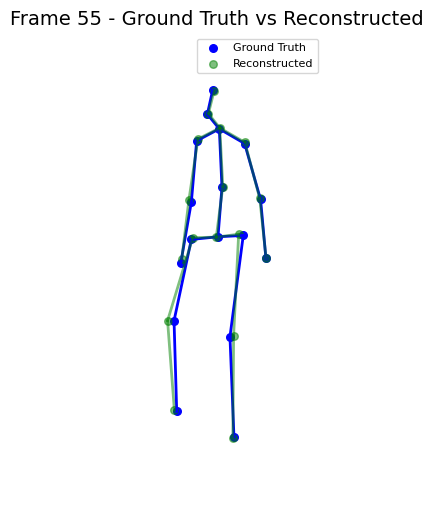

Showing frame 1927 (Worst Case)


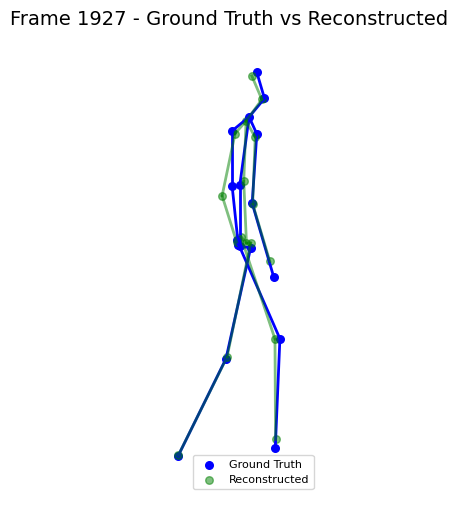

In [15]:
print(f"Showing frame {best_frame_idx} (Best Case)")
show_frame(best_frame_idx)  # Best Case Frame
print(f"Showing frame {worst_frame_idx} (Worst Case)")
show_frame(worst_frame_idx) # Worst Case Frame

In [16]:
import cv2

def write_skeleton_video(
    keypoints_all,   # shape: (num_frames, 17, 2)
    draw_skeleton_frame_fn,  # function to draw a single frame, yes you can pass a function as an argument to another function
    output_path,
    fps=50,
    width=640,
    height=480,
    start_frame=0,
    frame_count=200
):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for f in tqdm(range(start_frame, start_frame + frame_count)):
        keypoints = keypoints_all[f]
        frame_img = draw_skeleton_frame_fn(keypoints, f)
        video.write(frame_img)

    video.release()
    print('\n',f"Video saved to: {output_path}")

In [17]:
from scipy.ndimage import gaussian_filter1d

def smooth_trajectory(keypoints_2d, sigma=2.0):
    smoothed = np.zeros_like(keypoints_2d) #creates an array of zeros with the same shape as keypoints_2d (num_frames, num_joints, 2)

    # Smoothing each joint and coordinate separately
    for joint in range(keypoints_2d.shape[1]): #here keypoints_2d.shape[1] gives the number of joints, if it were keypoints_2d.shape[0] it would give the number of frames
        for coord in range(2):  # x and y
            smoothed[:, joint, coord] = gaussian_filter1d(
                keypoints_2d[:, joint, coord],
                sigma=sigma,
                mode='nearest'  # Handles edge effects
            )

    return smoothed

In [18]:
width, height = 800, 800  # final video resolution

def draw_skeleton_frame(keypoints, frame_idx=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    x_margin = 50
    y_margin = 50
    x_min, x_max = keypoints[:, 0].min(), keypoints[:, 0].max()
    y_min, y_max = keypoints[:, 1].min(), keypoints[:, 1].max()

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(-(y_max + y_margin), -(y_min - y_margin))
    ax.set_aspect('equal')
    ax.axis('off')

    ax.scatter(keypoints[:, 0], -keypoints[:, 1], c='blue', s=20) # here s is the size of the points
    for i, j in skeleton_edges:
        x = [keypoints[i, 0], keypoints[j, 0]]
        y = [-keypoints[i, 1], -keypoints[j, 1]]
        ax.plot(x, y, 'b-', lw=2)

    if frame_idx is not None:
        ax.set_title(f"Frame {frame_idx}", fontsize=12)

    fig.tight_layout()
    fig.canvas.draw()
    img = np.asarray(fig.canvas.buffer_rgba()) # Converting the canvas to a numpy array
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR) # Converting RGBA to BGR for OpenCV compatibility, RGBA is a color format used by matplotlib, while OpenCV uses BGR.
    img_bgr = cv2.resize(img_bgr, (width, height))
    plt.close(fig)
    return img_bgr # this returns with skeleton drawn on it

In [19]:
sigma = 3  # Increase for more smoothing but dont go too high or observe it if you want
smoothed_keypoints = smooth_trajectory(keypoints_reconstructed, sigma=sigma)
write_skeleton_video(
    smoothed_keypoints,
    draw_skeleton_frame,
    output_path='smoothed_skeleton_video.mp4',
    fps=50,
    width=800,
    height=800,
    start_frame=70,
    frame_count=3000
)

100%|██████████| 3000/3000 [02:44<00:00, 18.24it/s]


 Video saved to: smoothed_skeleton_video.mp4


In [20]:
sigma = 3  # Increase for more smoothing but dont go too high or observe it if you want
smoothed_keypoints = smooth_trajectory(keypoints_all, sigma=sigma)
write_skeleton_video(
    smoothed_keypoints,
    draw_skeleton_frame,
    output_path='skeleton_video.mp4',
    fps=50,
    width=800,
    height=800,
    start_frame=70,
    frame_count=3000
)

100%|██████████| 3000/3000 [03:07<00:00, 15.98it/s]


 Video saved to: skeleton_video.mp4


In [21]:
subprocess.run(['start', 'smoothed_skeleton_video.mp4'], shell=True) # This is for Windows to open the video file automatically after saving it

CompletedProcess(args=['start', 'smoothed_skeleton_video.mp4'], returncode=0)

In [22]:
subprocess.run(['start', 'skeleton_video.mp4'], shell=True)

CompletedProcess(args=['start', 'skeleton_video.mp4'], returncode=0)

In [23]:
# Just to compare the original and smoothed videos side by side, we will create a new video that combines both.
width, height = 800, 800
fps = 50  # frames per second
vid1 = cv2.VideoCapture('skeleton_video.mp4')
vid2 = cv2.VideoCapture('smoothed_skeleton_video.mp4')

# ------------ Video writer ------------
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('smooth_compare.mp4', fourcc, fps, (width * 2, height))

while True:
    ret1, frame1 = vid1.read()
    ret2, frame2 = vid2.read()
    if not ret1 or not ret2:
        break
    # Stacking frames horizontally
    combined_frame = cv2.hconcat([frame1, frame2])
    out.write(combined_frame)

vid1.release() # It is necessary to release the video capture objects, it will free up a lot of resources cv2 has used.
vid2.release()
out.release()

In [24]:

subprocess.run(['start', 'smooth_compare.mp4'], shell=True) # again this is for Windows!

CompletedProcess(args=['start', 'smooth_compare.mp4'], returncode=0)

> **A little surprise (or maybe a shock):**
> Logically speaking, we want the intermediate frames to be filled and for that, even averaging might work. So, why use a BiLSTM or ConvLSTM? In fact, spline interpolation, as we saw in `week-04`, outperformed these methods by almost a factor of 10.
>
> If all we need is a basic fill-in, then a simple MLP (Multi-Layer Perceptron) can easily outperform BiLSTMs and even spline interpolation. Try it yourself.
>
> Then why did we use a BiLSTM at all? Recall from `week-03` that predicting the **next frame** is a foundational step behind **GPT-based text generation**. In that sense, we are now approaching a prediction setup where we’re not just reconstructing data, we’re *generating* it.
>
> This shifts the task from imputation to **conditional generation**, which is central to **video generation**. If we give the model a little context about what it's predicting, such as an *action label* like "Walking" or "Running" — this starts resembling the use of a **prompt** in language models. The key idea here is to integrate **attention mechanisms** to allow the model to *focus* on relevant temporal context, improving both quality and diversity of output.
>
> Currently, we only trained on `S7`, `Walking`, `Camera 0`, which is just 3637 frames. But we do have both data (frames) and context (e.g., activity labels). That opens the door for **attention-based architectures** that condition predictions on activity type or past motion history.

### 🔗 Suggested Videos to Learn More About Attention:

1. [**Attention for Neural Networks | StatQuest**](https://www.youtube.com/watch?v=PSs6nxngL6k)

2. [**Attention in transformers | 3blue1brown**](https://www.youtube.com/watch?v=eMlx5fFNoYc)

3. [**Transformer Neural Networks | StatQuest**](https://www.youtube.com/watch?v=zxQyTK8quyY)

4. [**This is a nice repo on Transformers**](https://jalammar.github.io/illustrated-transformer/)
---

# **Thank you!**

It has been a wonderful journey of learning, experimenting, and growing together. We truly enjoyed mentoring and collaborating with all of you throughout this project. Always tell us where we can do better.

**With best wishes,**

**Your mentors and Friends,**

**Yaswanth and Harshit**

